# Setup

## Imports

In [15]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(100)

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import metrics
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

path = r"../../../data/raw/formula-1-world-championship-1950-2020/versions/24/"

## Reader Files

In [2]:
def create_dataframes_csv(path):
    frame = pd.read_csv(path)
    
    return frame

In [3]:
def prefix_columns(df, table_name, exclude=None):
    if exclude is None:
        exclude = []
    return df.rename(columns={
        col: f"{table_name}__{col}" if col not in exclude else col
        for col in df.columns
    })

drivers = prefix_columns(create_dataframes_csv(f"{path}drivers.csv"), "drivers")
constructors = prefix_columns(create_dataframes_csv(f"{path}constructors.csv"), "constructors")
constructor_standings = prefix_columns(create_dataframes_csv(f"{path}constructor_standings.csv"), "constructor_standings")
qualifying = prefix_columns(create_dataframes_csv(f"{path}qualifying.csv"), "qualifying")
circuits = prefix_columns(create_dataframes_csv(f"{path}circuits.csv"), "circuits")
results = prefix_columns(create_dataframes_csv(f"{path}results.csv"), "results")
pit_stops = prefix_columns(create_dataframes_csv(f"{path}pit_stops.csv"), "pit_stops")
races = prefix_columns(create_dataframes_csv(f"{path}races.csv"), "races")

drivers = drivers.drop(columns=[
    "drivers__url", "drivers__dob"
])

constructors = constructors.drop(columns=[
    "constructors__url"
])

constructor_standings = constructor_standings.drop(columns=[
    "constructor_standings__positionText"
])

circuits = circuits.drop(columns=[
    "circuits__url", "circuits__alt", "circuits__lng", "circuits__lng"
])

results = results.drop(columns=[
    "results__positionText"
])

races = races.drop(columns=[
    "races__url"
])

total = pd.merge(drivers, results, left_on="drivers__driverId", right_on="results__driverId")
total = pd.merge(total, races, left_on="results__raceId", right_on="races__raceId")
total = pd.merge(total, circuits, left_on="races__circuitId", right_on="circuits__circuitId")
total = pd.merge(total, qualifying, left_on=["races__raceId", "drivers__driverId"], right_on=["qualifying__raceId", "qualifying__driverId"])
total = pd.merge(total, pit_stops, left_on=["qualifying__raceId", "qualifying__driverId"], right_on=["pit_stops__raceId", "pit_stops__driverId"])
total = pd.merge(total, constructors, left_on="qualifying__constructorId", right_on="constructors__constructorId")
total = pd.merge(total, constructor_standings, left_on="constructors__constructorId", right_on="constructor_standings__constructorId")

total = total.drop(columns=[
    "drivers__driverId",
    "results__driverId", "results__raceId", "results__constructorId", "results__statusId", "results__number", "results__driverId",
    "races__raceId", "races__circuitId",
    "circuits__circuitId",
    "qualifying__qualifyId", "qualifying__raceId", "qualifying__driverId", "qualifying__constructorId", "qualifying__number",
    "pit_stops__driverId",
    "constructors__constructorId",
    "constructor_standings__constructorStandingsId", "constructor_standings__raceId", "constructor_standings__constructorId"
])

total = total.drop_duplicates()

total


,drivers__driverRef,drivers__number,drivers__code,drivers__forename,drivers__surname,drivers__nationality,results__resultId,results__grid,results__position,results__positionOrder,...,pit_stops__lap,pit_stops__time,pit_stops__duration,pit_stops__milliseconds,constructors__constructorRef,constructors__name,constructors__nationality,constructor_standings__points,constructor_standings__position,constructor_standings__wins
0,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,14.0,1,1
1,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,24.0,1,1
2,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,28.0,3,1
3,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,34.0,3,1
4,hamilton,44,HAM,Lewis,Hamilton,British,20780,2,2,2,...,16,17:28:24,23.227,23227,mclaren,McLaren,British,42.0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5020547,doohan,61,DOO,Jack,Doohan,Australian,26759,17,15,15,...,22,17:37:42,22.080,22080,alpine,Alpine F1 Team,French,14.0,9,0
5020548,doohan,61,DOO,Jack,Doohan,Australian,26759,17,15,15,...,22,17:37:42,22.080,22080,alpine,Alpine F1 Team,French,49.0,6,0
5020549,doohan,61,DOO,Jack,Doohan,Australian,26759,17,15,15,...,22,17:37:42,22.080,22080,alpine,Alpine F1 Team,French,49.0,7,0
5020550,doohan,61,DOO,Jack,Doohan,Australian,26759,17,15,15,...,22,17:37:42,22.080,22080,alpine,Alpine F1 Team,French,59.0,6,0


In [4]:
print(total.columns)

Index(['drivers__driverRef', 'drivers__number', 'drivers__code',
       'drivers__forename', 'drivers__surname', 'drivers__nationality',
       'results__resultId', 'results__grid', 'results__position',
       'results__positionOrder', 'results__points', 'results__laps',
       'results__time', 'results__milliseconds', 'results__fastestLap',
       'results__rank', 'results__fastestLapTime', 'results__fastestLapSpeed',
       'races__year', 'races__round', 'races__name', 'races__date',
       'races__time', 'races__fp1_date', 'races__fp1_time', 'races__fp2_date',
       'races__fp2_time', 'races__fp3_date', 'races__fp3_time',
       'races__quali_date', 'races__quali_time', 'races__sprint_date',
       'races__sprint_time', 'circuits__circuitRef', 'circuits__name',
       'circuits__location', 'circuits__country', 'circuits__lat',
       'qualifying__position', 'qualifying__q1', 'qualifying__q2',
       'qualifying__q3', 'pit_stops__raceId', 'pit_stops__stop',
       'pit_stops__lap', 

# Fastest lap prediction

### Dataset

In [5]:
def time_to_seconds(t):
    try:
        if t == "0:00.000" or pd.isna(t):
            return 0.0
        mins, rest = t.split(":")
        return int(mins) * 60 + float(rest)
    except:
        return 0.0

circuit = input(str("Circuit: "))

fastes_lap_data = pd.DataFrame()

fastes_lap_data = total[["drivers__code", "drivers__number", "drivers__nationality", 
                         "circuits__name",
                         "qualifying__q1", "qualifying__q2", "qualifying__q3",
                         "results__fastestLapTime",
                         "races__date"]]

fastes_lap_data = fastes_lap_data.drop_duplicates()

for index, row in fastes_lap_data.iterrows():
    if (str(row["circuits__name"]).lower() != circuit.lower()):
        fastes_lap_data.drop(index, inplace=True)

fastes_lap_data[["qualifying__q1", "qualifying__q2", "qualifying__q3"]] = \
    fastes_lap_data[["qualifying__q1", "qualifying__q2", "qualifying__q3"]].fillna("0:00.000")

for col in ["qualifying__q1", "qualifying__q2", "qualifying__q3"]:
    fastes_lap_data[col] = fastes_lap_data[col].apply(time_to_seconds)

meta = fastes_lap_data[["races__date", "drivers__code", "drivers__number", "circuits__name"]].reset_index(drop=True)

X_full = pd.concat([fastes_lap_data[["qualifying__q1", "qualifying__q2", "qualifying__q3"]],
                    pd.get_dummies(fastes_lap_data[["drivers__code", "drivers__number", 
                                                    "drivers__nationality", "circuits__name"]], drop_first=True)],
                   axis=1)

fastes_lap_data["fastestLapSeconds"] = fastes_lap_data["results__fastestLapTime"].apply(time_to_seconds)
y_full = fastes_lap_data["fastestLapSeconds"]


In [6]:
fastes_lap_data

,drivers__code,drivers__number,drivers__nationality,circuits__name,qualifying__q1,qualifying__q2,qualifying__q3,results__fastestLapTime,races__date,fastestLapSeconds
102853,HAM,44,British,Red Bull Ring,69.514,69.092,0.000,1:12.217,2014-06-22,72.217
115358,HAM,44,British,Red Bull Ring,72.218,69.062,68.455,1:11.475,2015-06-21,71.475
127253,HAM,44,British,Red Bull Ring,66.947,66.228,67.922,1:08.411,2016-07-03,68.411
140978,HAM,44,British,Red Bull Ring,65.064,64.800,64.424,1:07.411,2017-07-09,67.411
149823,HAM,44,British,Red Bull Ring,64.080,63.577,63.149,1:07.241,2018-07-01,67.241
...,...,...,...,...,...,...,...,...,...,...
4868528,DEV,21,Dutch,Red Bull Ring,65.974,0.000,0.000,1:09.852,2023-07-02,69.852
4880091,PIA,81,Australian,Red Bull Ring,65.683,65.605,0.000,1:09.862,2023-07-02,69.862
4924683,PIA,81,Australian,Red Bull Ring,65.311,65.070,65.048,1:08.697,2024-06-30,68.697
4961548,SAR,2,American,Red Bull Ring,65.948,0.000,0.000,1:09.611,2023-07-02,69.611


## Trainen

In [7]:
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X_full, y_full, meta, test_size=0.5, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))


MAE: 0.8951288617886154


In [8]:
results_df = pd.DataFrame({
    "Date": meta_test["races__date"].values,
    "Driver": meta_test["drivers__code"].values,
    "Number": meta_test["drivers__number"].values,
    "Circuit": meta_test["circuits__name"].values,
    "Predicted (s)": y_pred,
    "Actual (s)": y_test.values
})

results_df["Date"] = pd.to_datetime(results_df["Date"])
results_df = results_df.sort_values(by=["Date", "Actual (s)"])

results_df


,Date,Driver,Number,Circuit,Predicted (s),Actual (s)
112,2014-06-22,PER,11,Red Bull Ring,72.69995,72.142
110,2014-06-22,HAM,44,Red Bull Ring,72.44704,72.217
43,2014-06-22,ALO,14,Red Bull Ring,72.65477,72.595
0,2014-06-22,RAI,7,Red Bull Ring,72.60162,72.884
118,2014-06-22,RIC,3,Red Bull Ring,72.47306,73.060
...,...,...,...,...,...,...
45,2024-06-30,GAS,10,Red Bull Ring,69.55948,69.609
117,2024-06-30,OCO,31,Red Bull Ring,69.39663,69.649
79,2024-06-30,MAG,20,Red Bull Ring,69.51356,70.125
108,2024-06-30,STR,18,Red Bull Ring,69.33933,70.143


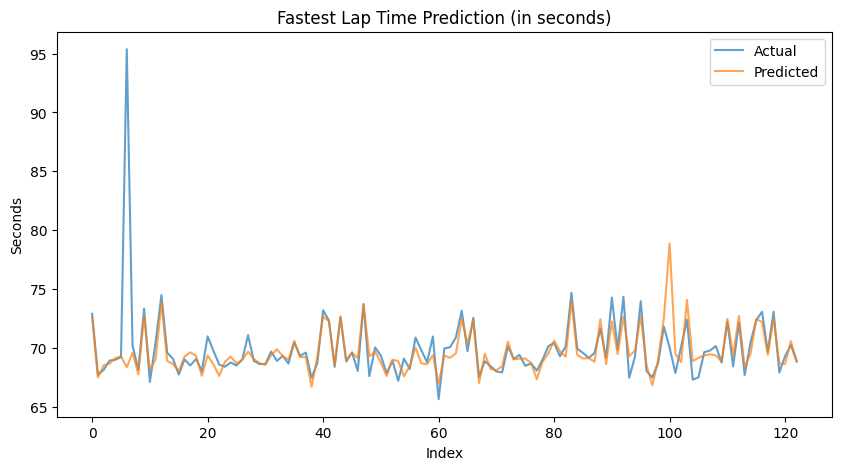

In [9]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual", alpha=0.7)
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.title("Fastest Lap Time Prediction (in seconds)")
plt.ylabel("Seconds")
plt.xlabel("Index")
plt.legend()
plt.show()


## Decision Tree

Regressor wordt gebruikt i.p.v. Class, omdat er gewerkt wordt met float nummers, inplaats van normale nummers

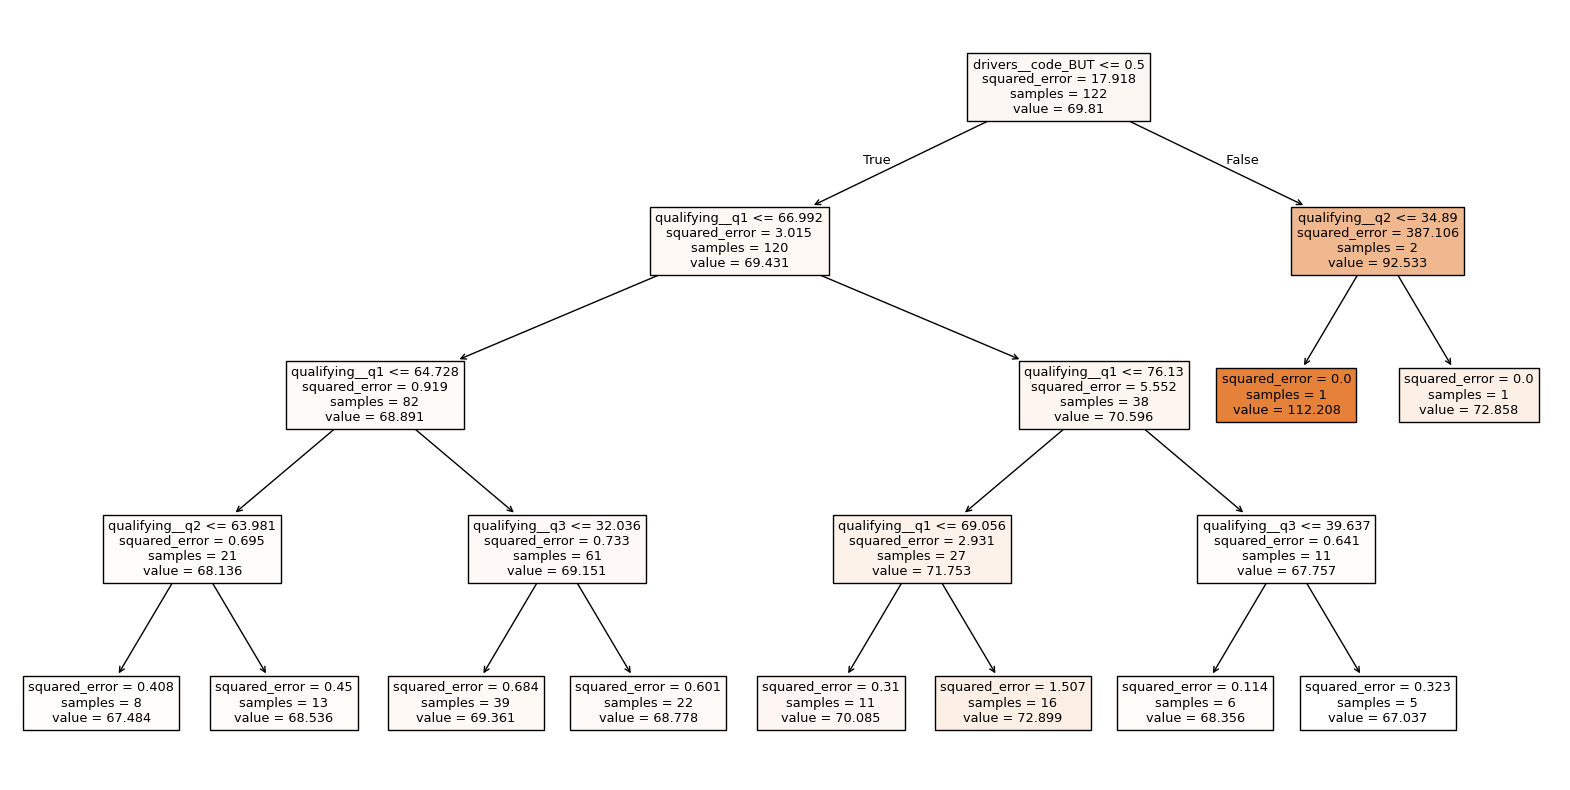

In [10]:
dtree = DecisionTreeRegressor(max_depth=4, random_state=42)
dtree.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
tree.plot_tree(dtree, feature_names=X_train.columns, filled=True)
plt.show()


## Confusion Matrix

In [11]:
def predict(X_test, y_test, predict_column_name, y_column_name):
    predicted_df = pd.DataFrame(dtree.predict(X_test), columns=[predict_column_name])
    actual_df = y_test.reset_index(drop=True).to_frame(name=y_column_name)
    return pd.concat([actual_df, predicted_df], axis=1)


In [12]:
model_results_frame = predict(X_test, y_test, "Predicted (s)", "Actual (s)")
model_results_frame

,Actual (s),Predicted (s)
0,72.884,72.899000
1,67.712,67.484500
2,68.117,68.536462
3,68.900,68.778318
4,68.971,69.361128
...,...,...
118,73.060,72.899000
119,67.894,68.536462
120,69.288,69.361128
121,70.228,70.085091


In [13]:
actual = []
predicted = []

for x in model_results_frame["Actual (s)"]:
    actual.append(int(x))
    
for x in model_results_frame["Predicted (s)"]:
    predicted.append(int(x))
    
print(len(actual), len(predicted))

123 123


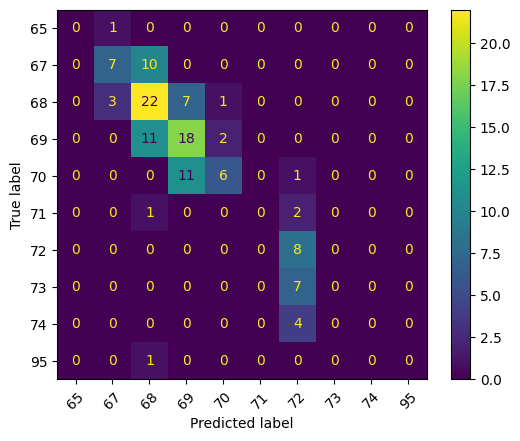

In [14]:
labels = sorted(set(actual) | set(predicted))

confusion_matrix = metrics.confusion_matrix(
    actual,
    predicted
)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
cm_display.plot()
plt.xticks(rotation=45)
plt.show()


## Neural Network Regression

In [30]:
ct = make_column_transformer(
    (MinMaxScaler(), ["qualifying__q1", "qualifying__q2", "qualifying__q3"])
)

ct.fit(X_train)
X_train_normalized = ct.transform(X_train)
X_test_normalized = ct.transform(X_test)
X_train_normalized

array([[0.82388093, 0.53000284, 0.88829787],
       [0.78514255, 0.50460186, 0.78639483],
       [0.78713446, 0.50508335, 0.79230636],
       [0.8023243 , 0.51450019, 0.80109345],
       [0.85641138, 0.54837869, 0.85791331],
       [0.8023854 , 0.51761809, 0.80300637],
       [0.80017353, 0.        , 0.        ],
       [0.80254427, 0.51455544, 0.79995804],
       [0.80728575, 0.        , 0.        ],
       [0.78495925, 0.50498074, 0.78565434],
       [0.82631277, 0.        , 0.        ],
       [0.78307732, 0.50183916, 0.77934788],
       [0.99155577, 0.6331381 , 0.        ],
       [0.79442998, 0.        , 0.        ],
       [0.95681343, 0.61519639, 0.99334798],
       [0.81397026, 0.        , 0.        ],
       [0.82036148, 0.52780058, 0.87812855],
       [0.78946854, 0.50758556, 0.        ],
       [0.81701311, 0.        , 0.        ],
       [0.80641811, 0.52004925, 0.        ],
       [0.80331415, 0.        , 0.        ],
       [0.78759883, 0.5067094 , 0.79205953],
       [0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4433 - mae: 1.4433  
[1.300716757774353, 1.300716757774353]


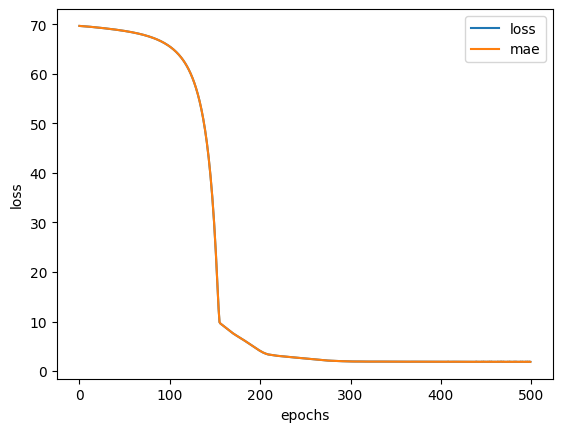

In [66]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1)
])

model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.0015),
                metrics=["mae"]
)

history = model_1.fit(X_train_normalized, y_train, epochs=500, verbose=0)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")
print(model_1.evaluate(X_test_normalized, y_test))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Length of y_predict: 123
Length of y_test: 123
123 123 123


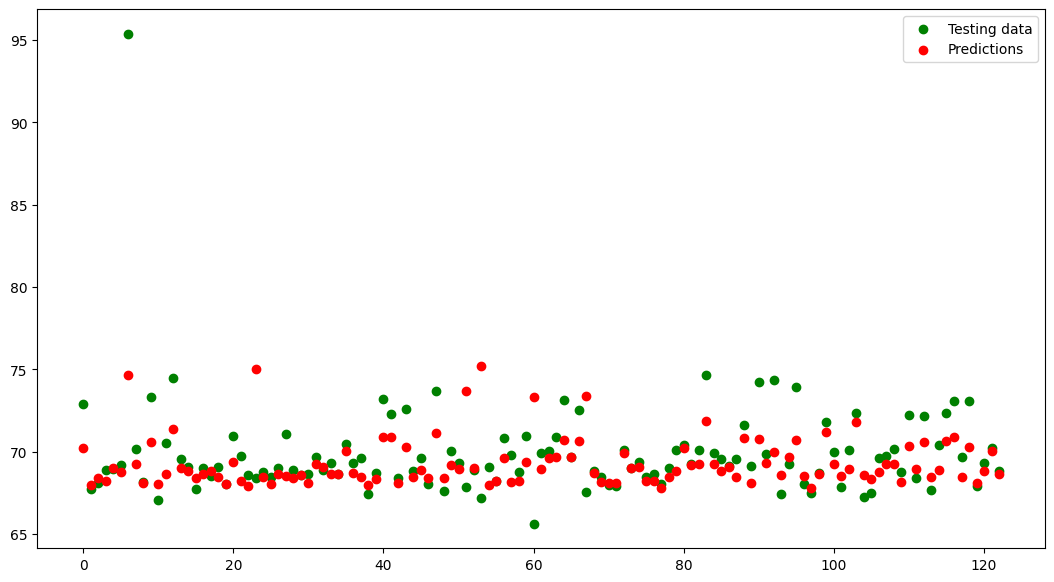

In [67]:
def plot_predictions(test_X, test_Y, pred_Y):
    plt.figure(figsize=(13, 7))
    plt.scatter(test_X, test_Y, c="g", label="Testing data")
    plt.scatter(test_X, pred_Y, c="r", label="Predictions")
    plt.legend()
    plt.show()

y_predict = model_1.predict(X_test_normalized)

y_test = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test
y_predict = tf.squeeze(y_predict).numpy() 

if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0].to_numpy() 

print(f"Length of y_predict: {len(y_predict)}")
print(f"Length of y_test: {len(y_test)}")

test_X = tf.range(0, len(y_test)).numpy()

print(len(test_X), len(y_test), len(y_predict))

plot_predictions(test_X, y_test, y_predict)
